# Variational Quantum Classifier for Heart Disease Prediction

This notebook implements a Variational Quantum Classifier (VQC) to predict heart disease using the UCI Heart Disease dataset. The implementation follows a structured approach, including:

1. **Data Preprocessing**: Preparing the dataset for quantum processing.
2. **Quantum Circuit Design**: Defining the feature map and variational ansatz.
3. **Training**: Optimizing the variational parameters using gradient descent.
4. **Evaluation**: Assessing the model's performance on a test set.

The notebook adheres to modern Qiskit practices and provides clear explanations for each step.

---

## Installing Required Packages

To ensure all necessary libraries are available for this notebook, we use `pip` to install the required Python packages. 

This approach guarantees that the environment contains the latest versions of essential tools for quantum computing, data processing, and visualization.  
The `%pip` magic command is used within Jupyter notebooks to install packages directly from a notebook cell, making the setup process straightforward and reproducible.

In [ ]:
# Quantum Computing Framework
%pip install qiskit
%pip install qiskit-aer
%pip install qiskit-ibm-runtime
%pip install qiskit[visualization]

# Data Science and Machine Learning
%pip install scikit-learn
%pip install numpy
%pip install pandas

# Visualization and Plotting
%pip install matplotlib
%pip install matplotlib_inline

# Optimization
%pip install cma

In [3]:
from qiskit import generate_preset_pass_manager
from qiskit.circuit.library import  real_amplitudes, zz_feature_map
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import cma

#some checks
import qiskit

print(f"Qiskit version: {qiskit.__version__}")

Qiskit version: 2.1.1


In [ ]:
print(f"Qiskit version: {qiskit.__version__}")

# Quantum Circuit Design
This section defines the quantum circuits used in the VQC:
1. **Feature Map**: Encodes classical data into quantum states using angle encoding.
2. **Variational Ansatz**: A parameterized quantum circuit with trainable parameters.
3. **Full Circuit**: Combines the feature map and ansatz into a single circuit.

In [4]:
# constants
n = 4
RANDOM_STATE = 42
LR = 1e-3
class_labels = ['yes', 'no']

service = QiskitRuntimeService(name="freeya")
service.saved_accounts()

{'freeya': {'channel': 'ibm_cloud',
  'url': 'https://cloud.ibm.com',
  'token': 'WFEaV3EHSzrxoRC8FzihDeKUeRAsamcJvM8ELuVhCseq',
  'instance': 'crn:v1:bluemix:public:quantum-computing:eu-de:a/452ba97997904d3fbcd867e150d43588:20b21d0c-0815-4cde-9b66-5824f70ec2b3::',
  'verify': True,
  'private_endpoint': False}}

In [5]:
# Normalize the data

def normalize_data(path='heartdata.csv'):
    """
    Normalize the data from the CSV file and return the features and labels.
    
    Args:
        path (str): Path to the CSV file containing the heart disease dataset.
        
    Returns:
        tuple: A tuple containing the normalized features and labels.
    """
    # Load the dataset
    df = pd.read_csv(path)
    
    # Shuffle the dataset
    df = shuffle(df, random_state=RANDOM_STATE)
    
    # Separate features and labels
    X, Y = df[['sex', 'cp', 'exang', 'oldpeak']].values, df['num'].values
    # normalize the data
    #X = normalize(X)
    scaler = MinMaxScaler(feature_range=(0, np.pi)) # Scale to [0, pi] for angle encoding
    X = scaler.fit_transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)
    return X_train, X_test, Y_train, Y_test

In [6]:
X_train, X_test, Y_train, Y_test = normalize_data()

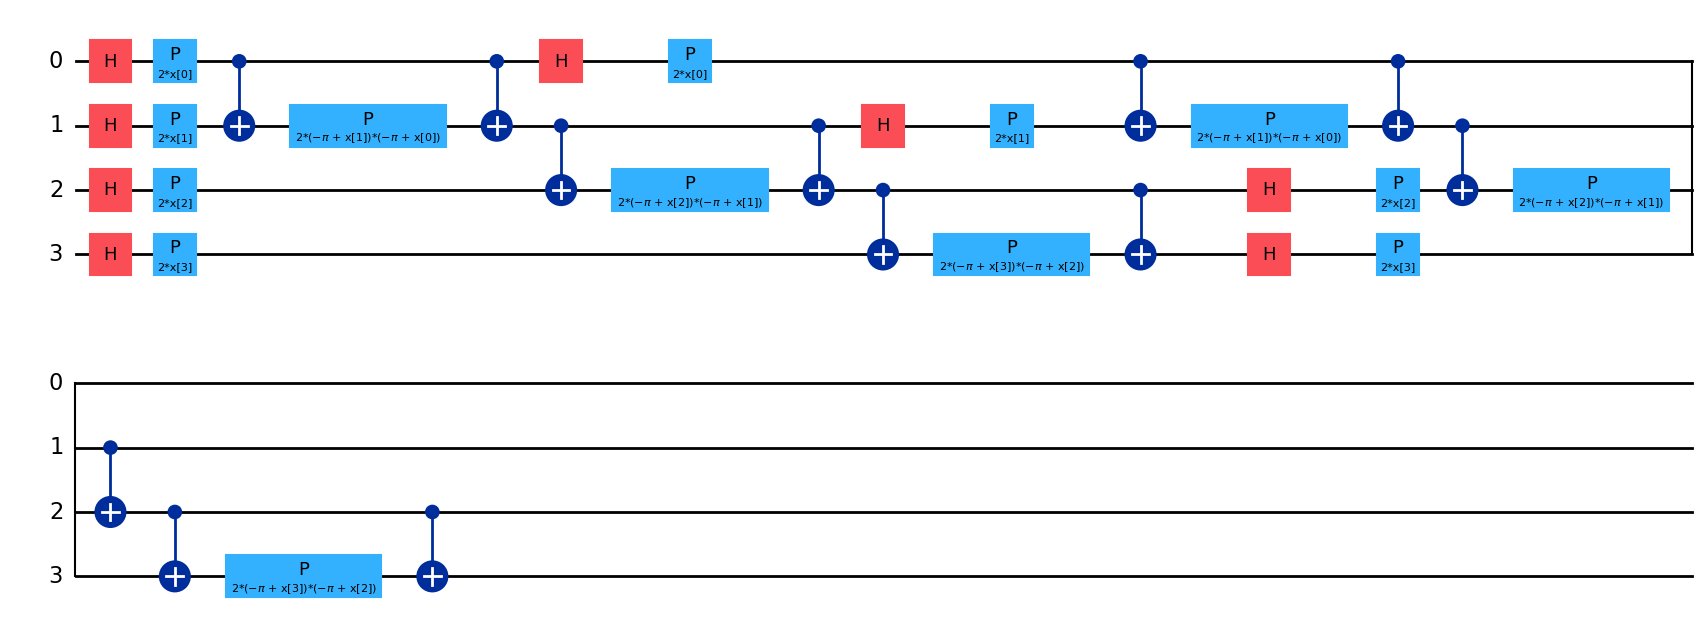

In [7]:
# Prepare the feature map
state = Statevector.from_label('0' * n)
feature_map = zz_feature_map(feature_dimension=n, reps=2, entanglement='linear')
feature_map.draw(output='mpl')

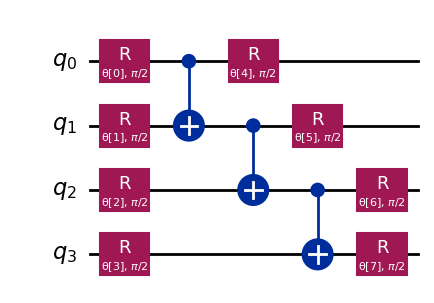

In [8]:
# Prepare the ansatz
ansatz = real_amplitudes(num_qubits=n, reps=1, entanglement='linear')
ansatz.decompose().draw(output='mpl')

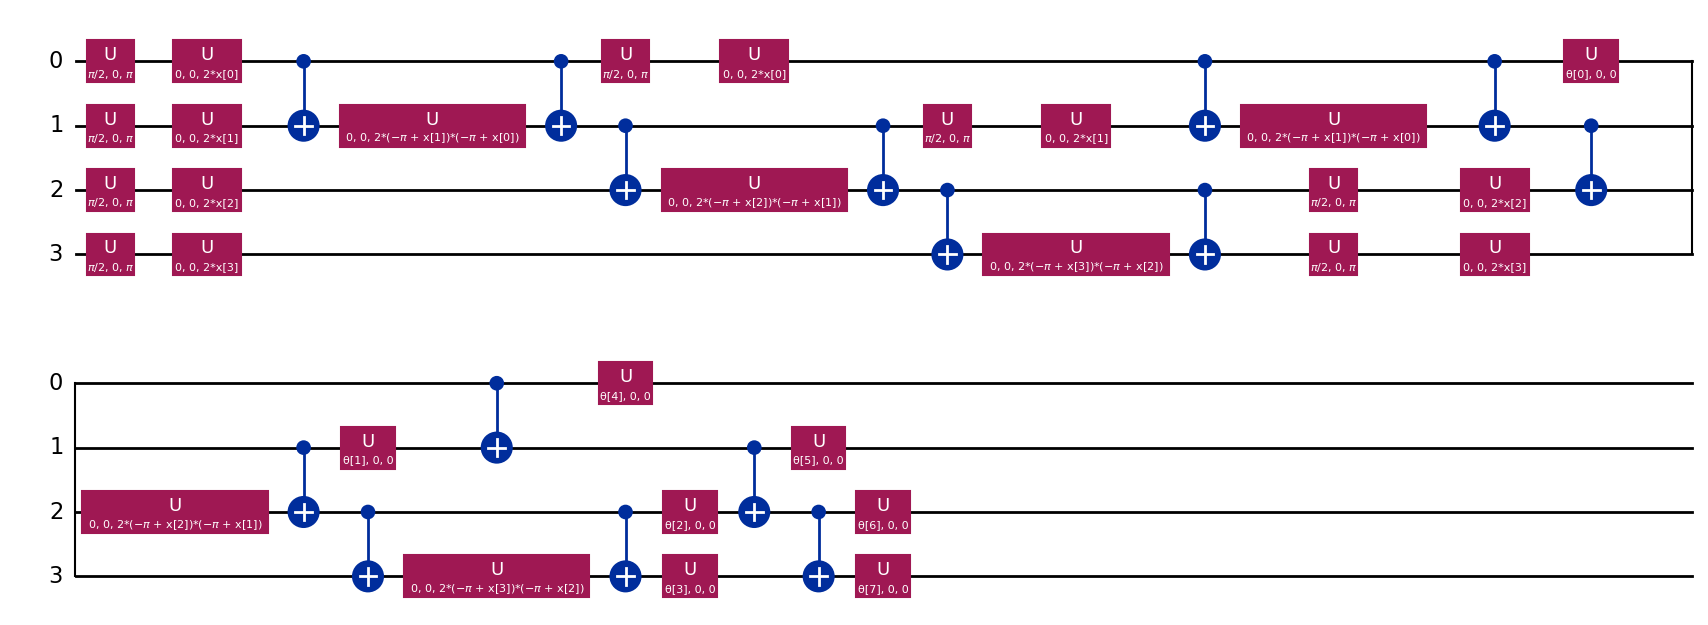

In [9]:
# Compose the circuit 
circuit = feature_map.compose(ansatz, inplace=False)
circuit.decompose(reps=8).draw(output='mpl')

In [10]:
def get_data_dict(params, x):
    """
    Create a dictionary of parameters for the feature map and ansatz.
    Args:
        params (list): List of parameters for the ansatz.
        x (list): List of features for the feature map.
    Returns:
        dict: A dictionary mapping parameters to their values."""
    parameters = {}
    for i, p in enumerate(feature_map.parameters):
        parameters[p] = x[i]
    for i, p in enumerate(ansatz.parameters):
        parameters[p] = params[i]
    return parameters

In [11]:
def assign_label(bit_string, class_labels):
    """
    Assign a label based on the parity of the Hamming weight of the bit string.
    Args:
        bit_string (str): A string of bits representing the quantum state.
        class_labels (list): A list of class labels, e.g., ['yes', 'no'].
    Returns:
        str: The assigned class label based on the parity of the Hamming weight.
    """
    hamming_weight = sum([int(bit) for bit in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

In [12]:
def return_probabilities(counts, class_labels):
    """
    Calculate the probabilities of each class label based on the counts of bit strings.
    Args:
        counts (dict): A dictionary containing the counts of bit strings.
        class_labels (list): A list of class labels, e.g., ['yes', 'no'].
    Returns:
        dict: A dictionary with class labels as keys and their probabilities as values.
    """
    shots = sum(counts.values())
    result = {class_labels[0]: 0, class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key] / shots
    return result

Depth of two-qubit gates:  12


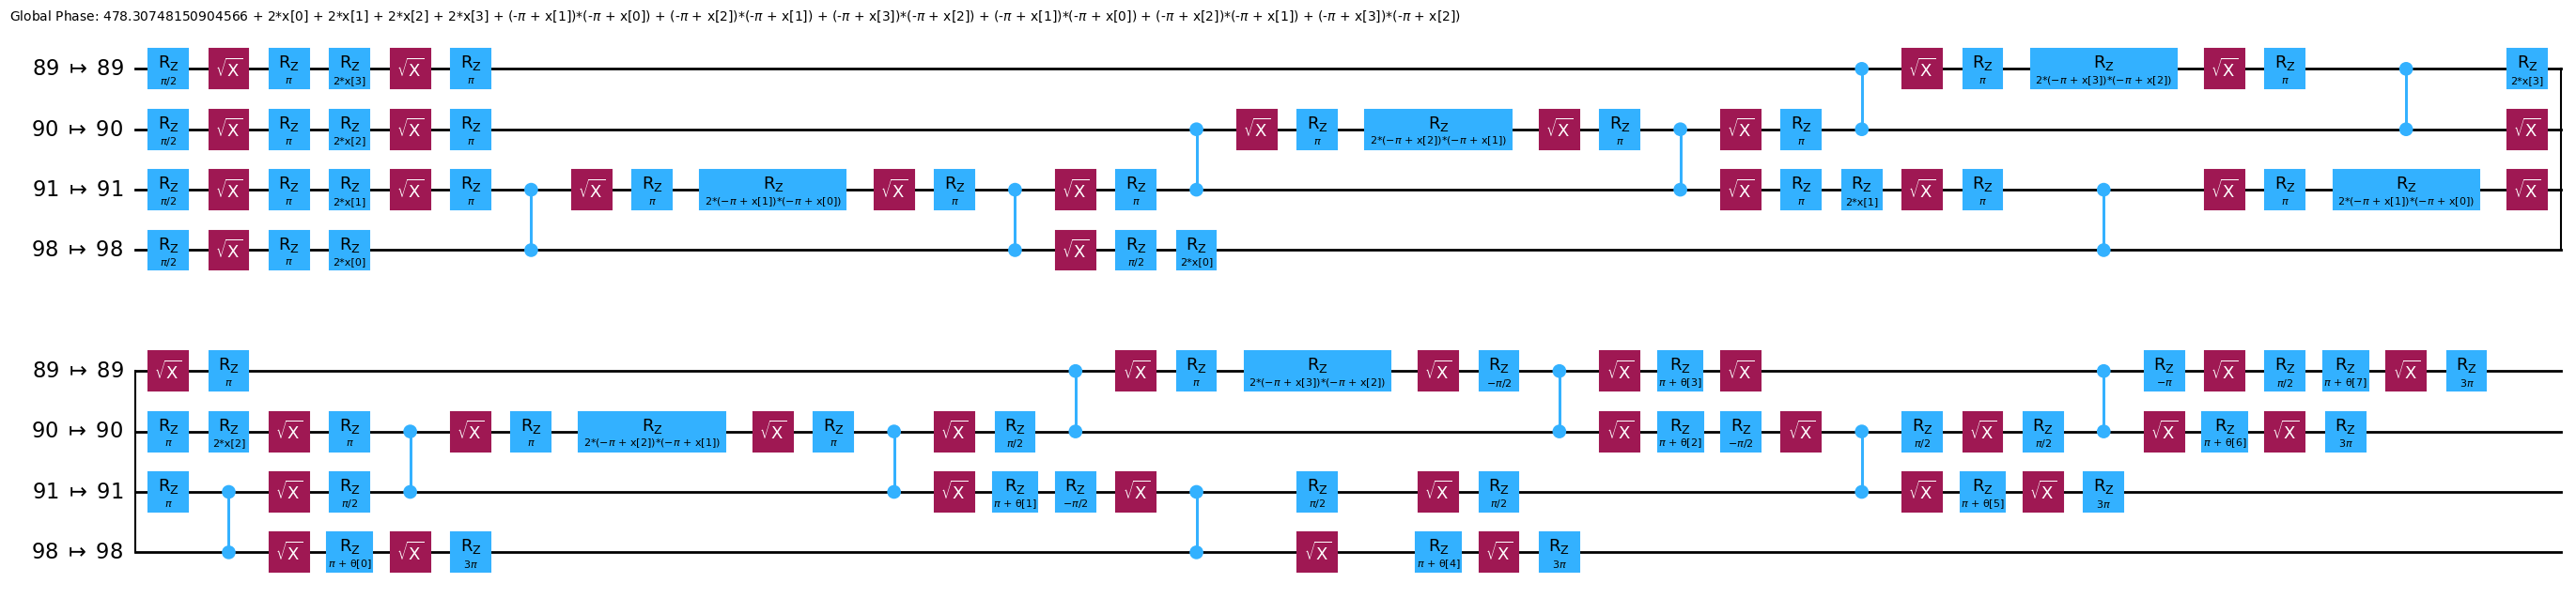

In [13]:
# Create a simulator backend
backend = service.backend("ibm_aachen")
aer_sim = AerSimulator().from_backend(backend)
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
sampler = Sampler(mode=aer_sim)


transpiled_circuit = pm.run(circuit)
print('Depth of two-qubit gates: ', transpiled_circuit.depth(lambda x: len(x.qubits) == 2))
transpiled_circuit.draw(output="mpl", idle_wires=False, fold=40)

In [14]:
def classify(x_list, params, class_labels, shots=1024):
    """
    Classify a list of feature vectors using the quantum circuit.
    Only for simulation purposes.

    Args:
        x_list (list): A list of feature vectors to classify.
        params (list): A list of parameters for the ansatz.
        shots (int): The number of shots for the simulation.
        class_labels (list): A list of class labels, e.g., ['yes', 'no'].
    Returns:
        dict: A dictionary with class labels as keys and their probabilities as values.
    """

    qc_list = []
    for x in x_list:
        classifier = circuit.assign_parameters(get_data_dict(params, x))
        classifier.measure_all()

        # Transpile the circuit
        transpiled_circuit = pm.run(classifier)
        qc_list.append(transpiled_circuit)

    # Run the circuits on the simulator
    results = sampler.run(qc_list, shots=shots).result()
    probs = []
    
    for qc in results:
        counts = qc.data.meas.get_counts()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs

In [15]:
def mse_cost(probs, expected_label):
    """
    Calculate the Mean Squared Error (MSE) cost function.
    Args:
        probs (dict): A dictionary with class labels as keys and their probabilities as values.
        expected_label (str): The expected class label for the cost calculation.
    Returns:
        float: The Mean Squared Error (MSE) between the actual and predicted probabilities.
    """
    p = probs.get(expected_label)
    actual, pred = np.array(1), np.array(p)
    return np.square(np.subtract(actual,pred)).mean()

In [16]:
def binary_cross_entropy(probs, expected_label):
    """
    Calculate the Binary Cross-Entropy (BCE) cost function.

    Args:
        probs (dict): A dictionary with class labels (as strings) as keys and their predicted probabilities as values.
        expected_label (str): The expected class label (e.g., 'yes' or 'no').

    Returns:
        float: The Binary Cross-Entropy loss.
    """
    eps = 1e-10  # for numerical stability

    # Get the predicted probability for the expected label
    p = probs.get(expected_label, 0.0)
    p = np.clip(p, eps, 1 - eps)  # Clip to avoid log(0)

    return -np.log(p)


In [17]:
def cost_function(X, Y, class_labels, params, cost_list, shots=1024, print_value=False, ):
    """
    Calculate the cost function for the given parameters and data.
    Args:
        X (list): List of feature vectors.
        Y (list): List of labels corresponding to the feature vectors.
        class_labels (list): List of class labels, e.g., ['yes', 'no'].
        params (list): List of parameters for the ansatz.
        cost_list (list): List to store the computed cost values.
        shots (int): Number of shots for the quantum circuit simulation.
        print_value (bool): Whether to print the computed cost value.
    Returns:
        float: The computed cost value.
    """
    cost = 0
    training_labels = []
    training_samples = []

    for sample in X:
        training_samples += [sample]
    for label in Y:
        if label == 0:
            training_labels += [class_labels[0]]
        elif label == 1:
            training_labels += [class_labels[1]]

    probs = classify(training_samples, params, class_labels, shots)
    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += binary_cross_entropy(prob, training_labels[i])
    cost /= len(training_samples)
    # print resulting objective function
    if print_value:
        print('%.4f' % cost)
    # return objective value
    cost_list.append(cost)
    return cost

In [31]:


cost_list = []

# Define the initial parameters for the ansatz
#np.random.seed(RANDOM_STATE)
init_params = 2*np.pi*np.random.rand(n*2*2)

# Define objective function
objective_function = lambda params: cost_function(X_train, Y_train, class_labels, params, cost_list, shots=1024, print_value=True)

# Optimize the parameters using the COBYLA optimizer
result = cma.fmin2(objective_function, sigma0=0.1,x0=init_params, options = {'maxfevals': 200,},noise_handler=cma.NoiseHandler(n*2*2))

# Print the optimized parameters and the final cost value
print(result)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 16 (seed=787079, Wed Jul 16 19:54:34 2025)
0.6794
0.7316
0.7380
0.7007
0.7719
0.6681
0.7265
0.6516
0.6360
0.6544
0.7679
0.6557
0.6762
0.7292
0.6335
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 6.359600974075668e-01 1.1e+00 9.24e-02  9e-02  9e-02 2:54.6
0.6548
0.6895
0.6465
0.7778
0.6736
0.6124
0.6613
0.6365
0.6585
0.6764
0.6538
0.6644
0.6568
0.6895
0.6122
    2     30 6.124123121201397e-01 1.2e+00 8.91e-02  9e-02  9e-02 5:51.5
0.6500
0.6282
0.6464
0.6063
0.6621
0.5989
0.6387
0.6511
0.6628
0.6011
0.6027


KeyboardInterrupt: 

In [25]:
result[1].best.x, result[1].best.f

(array([ 3.52119952,  5.95067499,  1.49995591,  0.88708294,  0.2367361 ,
         5.17412695,  1.28590858, -0.233659  ,  2.99544201,  5.60661679,
         5.90916167,  2.7908682 ,  0.17497716,  0.59980365,  5.7333609 ,
         2.24090665]),
 0.6105934875403343)

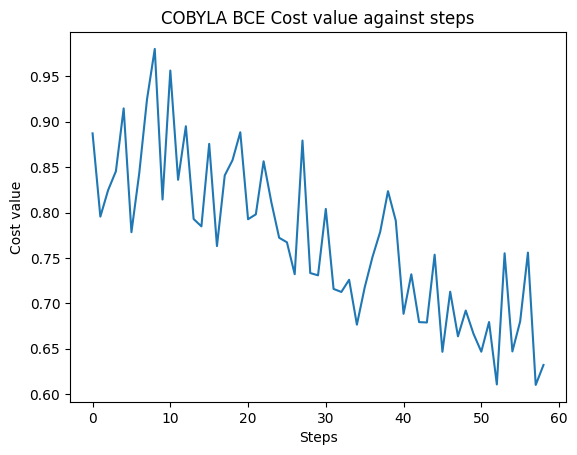

In [26]:
fig = plt.figure()
plt.plot(range(len(cost_list)), cost_list)
plt.xlabel('Steps')
plt.ylabel('Cost value')
plt.title("COBYLA BCE Cost value against steps")
plt.show()

In [27]:
def test_model(X, Y, class_labels, params):
    accuracy = 0
    training_labels = []
    training_samples = []
    for sample in X:
        training_samples += [sample]
    probs = classify(training_samples, params, class_labels=class_labels, shots=1024)
    for i, prob in enumerate(probs):
        if (prob.get('yes') >= prob.get('no')) and (Y[i] == 0):
            accuracy += 1
        elif (prob.get('no') >= prob.get('yes')) and (Y[i] == 1):
            accuracy += 1
    accuracy /= len(Y_test)
    print("Test accuracy: {}\n".format(accuracy))
    return accuracy


In [30]:
total = 0
iter = 30
for i in range (iter):
    total += test_model(X_test, Y_test, class_labels, result[1].best.x)
print(f"Average Test Accuracy over {iter} iterations: {total / iter}")


Test accuracy: 0.6363636363636364

Test accuracy: 0.6022727272727273

Test accuracy: 0.6136363636363636

Test accuracy: 0.6590909090909091

Test accuracy: 0.6022727272727273

Test accuracy: 0.625



KeyboardInterrupt: 